# A Pseudoproxy Experiment with GraphEM and pseudoPAGES2k

**Expected time to run through: TBD mins**

This tutorial demonstrates how to get a reconstruction using GraphEM, leveraging a simple pseudoproxy dataset generated from iCESM gridded, with the realistic spatial availability but full temporal availablity of the PAGES 2k version 2 dataset.
The pseudoproxies are generated based on the original iCESM simulated surface temperature (`tas`) plus white noise with `SNR=10`. While with LMR it is advantageous to have many redundant proxies (as long as they are unbiased, which is the case here), with GraphEM this can lead to some counter-intuitive difficulties, which we explain below.

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

## Data Preparation

In [2]:
# load a proxy database
job = cfr.ReconJob()
# job.proxydb = pd.read_pickle('./data/pseudoPAGES2k/pseudo.tpn_SNR10.pkl')
job.proxydb = pd.read_pickle('./data/pseudoPAGES2k/pseudo.tpn_SNR1.pkl')

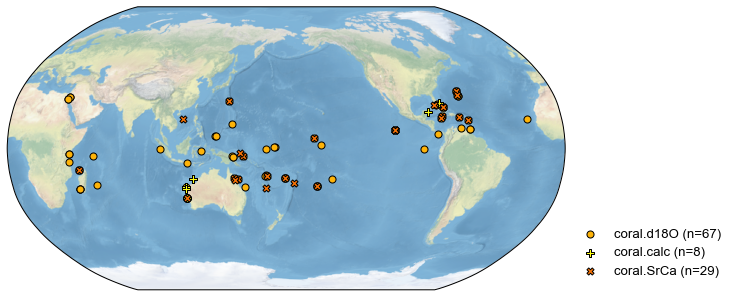

In [3]:
# filter the database
job.proxydb = job.proxydb.filter(by='ptype', keys='coral')
fig, ax = job.proxydb.plot()

In [4]:
job.proxydb = job.proxydb.center([1951, 1980])

Centering each of the ProxyRecord: 100%|██████████| 104/104 [00:00<00:00, 8644.45it/s]


In [5]:
# load observations
job.load_clim(
    tag='obs',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["obs_anom_period"] = (1951, 1980)
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> obs variables ['tas'] loaded
>>> job.obs created


In [6]:
# regrid and crop obs to make the problem size smaller
job.regrid_clim(tag='obs', nlat=42, nlon=63, verbose=True)
#job.regrid_clim(tag='obs', nlat=32, nlon=50, verbose=True)
job.crop_clim(tag='obs', lat_min=-25, lat_max=25, lon_min=120, lon_max=280, verbose=True)

>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> job.configs["prior_lat_min"] = -25
>>> job.configs["prior_lat_max"] = 25
>>> job.configs["prior_lon_min"] = 120
>>> job.configs["prior_lon_max"] = 280
>>> Processing tas ...


>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> job.obs updated


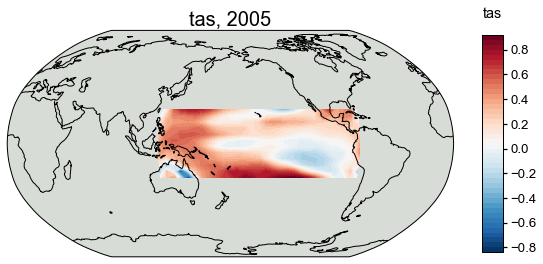

In [7]:
# annualize the observations
job.annualize_clim(tag='obs', verbose=True, months=list(range(1, 13)))
fig, ax = job.obs['tas'].plot(it=-1)

In [8]:
job.obs['tas'].da

<xarray.DataArray 'tas' (year: 1156, lat: 12, lon: 28)>
array([[[-1.43779302, -1.16293697, -1.01732908, ...,  0.39457998,
          0.52082612,  0.59373487],
        [-0.44181921, -0.51548275,  0.244261  , ...,  0.74474864,
          0.77145844,  0.68355714],
        [ 0.35079578,  0.32100882,  0.55368277, ...,  0.88217642,
          0.68757142,  0.31475473],
        ...,
        [ 0.72816369,  0.71887253,  0.54529944, ...,  0.20676015,
          0.30845679,  0.2907033 ],
        [ 1.10758701,  0.98782858,  1.00810014, ...,  0.09055938,
          0.18384386,  0.24694595],
        [ 1.31631178,  1.20505177,  1.04198581, ...,  0.14300547,
          0.29674634,  0.27620213]],

       [[-0.70474708, -0.01598469,  0.13178037, ..., -0.16622394,
         -0.03184134, -0.0226782 ],
        [-0.47576783, -0.55773132, -0.46185074, ..., -0.03219556,
          0.01012642,  0.01045555],
        [ 0.10615215, -0.04668079, -0.21236786, ...,  0.06428793,
         -0.00198371, -0.03837104],
...
        [ 0.25181528,  0.44903654,  0.61978375, ...,  0.31308888,
          0.36723991,  0.52567691],
        [ 0.04978446,  0.04787485,  0.22568625, ...,  0.45198041,
          0.4664865 ,  0.49749394],
        [ 0.10458478, -0.10605026, -0.21279729, ...,  0.54345012,
          0.54446683,  0.52080011]],

       [[ 0.0498074 ,  0.27873075,  0.39957376, ..., -0.03960866,
         -0.05272122,  0.16753688],
        [-0.37810031,  0.30122609, -0.0628949 , ..., -0.11026585,
          0.06519481,  0.26313251],
        [ 0.08783609, -0.448483  , -0.12010821, ..., -0.0352111 ,
          0.10163381,  0.12676614],
        ...,
        [ 0.09630422,  0.35422082,  0.39387372, ...,  0.24968949,
          0.3645677 ,  0.26936438],
        [-0.06625534,  0.26004941,  0.47504105, ...,  0.32676493,
          0.46907017,  0.4533393 ],
        [-0.19586628,  0.12946299,  0.54914526, ...,  0.38060853,
          0.41296104,  0.51346773]]])
Coordinates:
  * year     (year) int64 850 851 852 853 854 855 ... 2001 2002 2003 2004 2005
  * lon      (lon) float64 121.9 127.7 133.5 139.4 ... 261.3 267.1 272.9 278.7
  * lat      (lat) float64 -24.15 -19.76 -15.37 -10.98 ... 15.37 19.76 24.15

## Cross-validation

For this exercise we will use the same terminology as [scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html). Cross-validation is fundamental to model fitting, and is the most time-tested way to tune the parameters of a regression model such as GraphEM. Indeed, we can fit any graph to the data. The graph we want is the one that gives the "best" result. Best is in quotes because it may not always be possible to locate a unique optimum, so we may need to add other considerations. 

There are various [flavors of cross-validation](https://towardsdatascience.com/flavors-of-cross-validation-edfee24e8916) one can use. _k-fold cross-validation_ (typically with $k=5$) is a popular choice and what GraphEM implements (note: we could use the same approach to choose the localization radius in DA). This is what it looks like: the data are split in 5 groups. In each group, one withhold $1/k$ of the data for validation, using the remaining $(k-1)/k$ for calibration. 

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://scikit-learn.org/stable/_images/grid_search_cross_validation.png", width=600, height=400)

This process is repeated for various values of the tuning parameter (here, the cutoff radius) to construct a curve of some measure of expected prediction error (e.g. the mean square error, or MSE) vs the cutoff radius. That curve should have a U-shape, and the goal is to find the value of R that minimizes it. 

Below is a block of code in pseudocode that we need to 1) make run without bugs; 2) turn into a module of the `ReconJob` class, which could be called as `stats_kcv = job.graphem_kcv()`

In [23]:
%%time

# cross validation test
cutoff_radii=[500, 1000, 1500, 2000, 5000]

kcv_stats = job.graphem_kcv(
    cv_time=np.arange(1850, 2001), stat='MSE', n_splits=5,
    cutoff_radii=cutoff_radii,
)

>>> Processing fold 1:
>>> radius = 500
Using specified graph
Running GraphEM:

Iter     dXmis     rdXmis

001     0.2174     4.1596
002     0.2011     0.8931
003     0.0940     0.5290
004     0.1269     0.5234
005     0.0711     0.2148
006     0.0293     0.0761
007     0.0121     0.0297
008     0.0048     0.0115
009     0.0027     0.0063
010     0.0010     0.0025
>>> radius = 1000
Using specified graph
Running GraphEM:

Iter     dXmis     rdXmis

001     0.2174     4.1596
002     0.2099     0.9318
003     0.0786     0.2451
004     0.0721     0.1951
005     0.0411     0.1050
006     0.0189     0.0469
007     0.0090     0.0220
008     0.0036     0.0087
009     0.0015     0.0037
>>> radius = 1500
Using specified graph
Running GraphEM:

Iter     dXmis     rdXmis

001     0.2174     4.1596
002     0.2257     1.0021
003     0.0626     0.1633
004     0.0451     0.1111
005     0.0253     0.0608
006     0.0133     0.0315
007     0.0062     0.0147
008     0.0028     0.0065
009     0.0013     0.

Text(0.5, 1.0, 'K-fold Cross Validation')

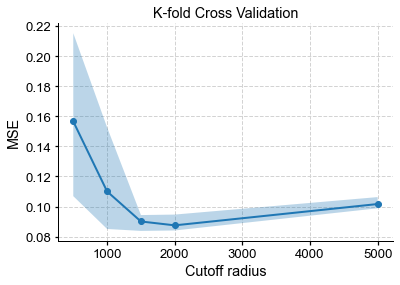

In [24]:
fig, ax = plt.subplots()
ax.plot(cutoff_radii, kcv_stats.mean(axis=0), '-o')
ax.fill_between(cutoff_radii, kcv_stats.min(axis=0), kcv_stats.max(axis=0), alpha=0.3)
ax.set_xlabel('Cutoff radius')
ax.set_ylabel('MSE')
ax.set_title('K-fold Cross Validation')

## After k-fold cross validation

The method `prep_graphem()` helps weave everything into an object that the code can work with:

In [9]:
job.prep_graphem(
    recon_period=(1001, 2000),
    calib_period=(1850, 2000),
    verbose=True)

>>> job.configs["recon_period"] = (1001, 2000)
>>> job.configs["recon_timescale"] = 1
>>> job.configs["calib_period"] = (1850, 2000)
>>> job.graphem_params["recon_time"] created
>>> job.graphem_params["calib_time"] created
>>> job.graphem_params["calib_idx"] created
>>> job.graphem_params["field"] created
>>> job.graphem_params["df_proxy"] created
>>> job.graphem_params["proxy"] created
>>> job.graphem_params["lonlat"] created


In [10]:
job.obs.keys()

dict_keys(['tas'])

In [11]:
job.graphem_params['field']

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.70970161, 0.73450522, 0.30319882, ..., 0.34267614, 0.25509715,
        0.39273508],
       [0.57543254, 0.4847614 , 0.17716476, ..., 0.26505406, 0.25998264,
        0.37178005],
       [0.66133266, 0.97367383, 1.02246066, ..., 0.0466115 , 0.12031657,
        0.13679344]])

In [12]:
job.graphem_params['df_proxy']

,Ocn_065,Ocn_075,Ocn_078,Ocn_167,Ocn_091,Ocn_093,Ocn_096,Ocn_086,Ocn_101,Ocn_070,...,Ocn_090,Ocn_119,Ocn_109,Ocn_097,Ocn_159,Ocn_087,Ocn_153,Ocn_169,Ocn_071,Ocn_072
1001,-0.029472,-0.079615,-0.164675,1.136972,-0.170487,-0.068706,0.001636,0.265989,0.029111,-0.060844,...,-0.016145,-0.023198,0.026751,-0.290637,-0.036539,-0.121053,-0.043656,-0.082111,-0.135477,-0.098504
1002,-0.021149,-0.096633,-0.120066,0.211940,-0.247028,-0.053001,0.014841,-0.099275,-0.163322,-0.069958,...,-0.651486,-0.012971,-0.026148,-0.209297,0.015105,0.072593,-0.088941,0.132871,-0.066113,-0.025315
1003,0.017044,0.177338,0.067678,-0.201700,0.062675,0.001354,0.009087,0.010825,0.001898,-0.107092,...,-0.184804,-0.250715,-0.002932,0.198525,-0.043845,0.095773,0.076952,0.905556,-0.117440,0.068865
1004,-0.072836,0.050557,-0.047072,-0.452527,-0.251116,0.059971,0.044815,0.041075,0.088916,-0.177990,...,-0.192031,-0.190020,0.028051,0.091881,-0.070303,0.038124,-0.014257,0.104113,0.022662,-0.027317
1005,0.036772,-0.181680,0.057200,-0.042987,0.042531,0.017662,-0.011964,-0.014553,-0.036732,0.045409,...,0.136227,-0.204292,-0.041819,-0.188765,-0.051463,-0.252486,0.095564,-0.581049,-0.271404,0.033542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,0.084822,0.202729,0.237921,-0.680074,-0.085530,0.000029,-0.077145,-0.059342,0.055956,0.283716,...,0.096534,0.287984,-0.026136,0.299611,0.096891,-0.002844,0.072604,0.326452,-0.042538,0.036153
1997,0.062888,0.627227,0.257458,0.895186,0.445891,0.036438,0.011253,0.408338,0.012960,0.111141,...,0.227277,-0.044239,0.068132,0.145206,-0.044438,-0.251896,0.106174,0.265856,-0.095977,-0.026760
1998,0.081860,0.218101,0.092819,-2.040758,0.530765,0.046501,0.162912,0.195244,0.074552,0.075628,...,0.248375,0.137352,0.128556,0.252945,0.006005,0.192609,0.046924,0.344340,-0.018421,0.002962
1999,0.053651,-0.316188,0.131558,0.182525,-0.043207,0.080396,-0.022788,0.234294,0.170416,0.076104,...,0.071616,0.122794,-0.010480,0.271125,0.021608,-0.088485,-0.014478,1.077392,0.440469,0.000934


In [13]:
print(np.shape(job.graphem_params['field']))
print(np.shape(job.graphem_params['proxy']))
print(np.shape(job.graphem_params['lonlat']))

(1000, 336)
(1000, 104)
(440, 2)


## Graph estimation

In GraphEM, the selection of the covariance model used for inferring missing values is based on a [graph](http://ir.hit.edu.cn/~jguo/docs/notes/report-in-princeton-research.pdf). 
Two types of graphs are supported:
1. Neighborhood graphs
2. Empirical graphs (graphical lasso)


## 1. Neighborhood graph as initial guess

In [14]:
g0 = cfr.graphem.Graph(
    job.graphem_params['lonlat'],
    job.graphem_params['field'],
    job.graphem_params['proxy'])

Let us define a neighborhood graph by including only points within a cutoff_radius $R$ of each grid point or proxy locale. The location takes a bit of time the first time around as the matrix of mutual great- circle distances needs to be computed: 

In [15]:
g0.neigh_adj(cutoff_radius=1500)

Next we plot the temperature neighbors of a particular proxy to show what happened:

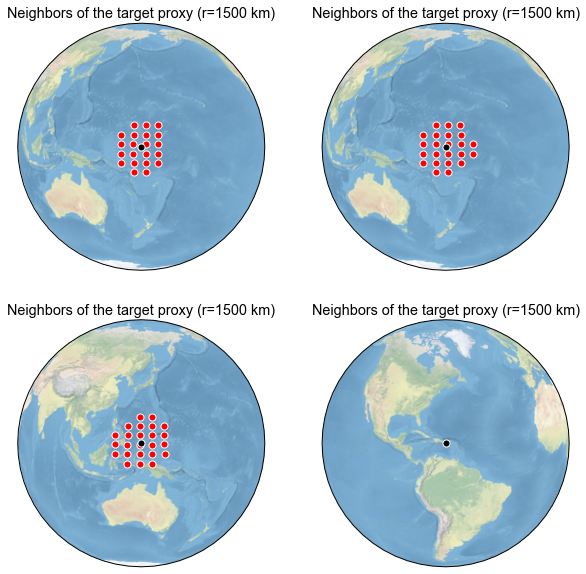

In [16]:
idcs = np.random.randint(0,job.graphem_params['df_proxy'].shape[1],4) # randomly pick indices
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.2, hspace=0.2)
ax = {}
for i, idx in enumerate(idcs):
    fig_map, ax_map = g0.plot_neighbors(idx)
    cfr.closefig(fig_map)  # mute the figure
    ax[idx] = fig.add_subplot(gs[i], projection=ax_map.projection)
    g0.plot_neighbors(idx,ax=ax[idx])

This, however, does not tell us the degree to which this proxy correlates to temperature at nerby grid points over the instrumental era. To do that, we use:

(<Figure size 360x360 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Neighbors of the target proxy (r=1500 km)'}>)

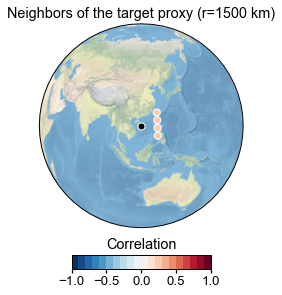

In [17]:
g0.plot_neighbors_corr(i)

This can be instructive for small proxy networks, or for debugging purposes. For a bird's eye view of the graph, we instead plot the adjacency matrix itself (dots indicate neighbors):

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:xlabel='Index'>)

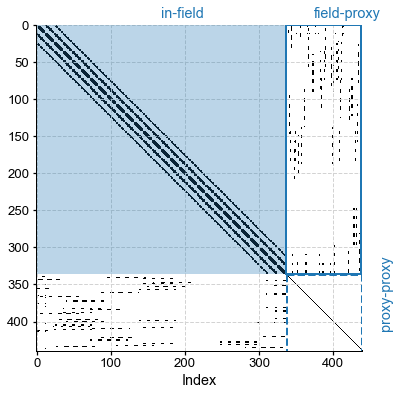

In [18]:
g0.plot_adj()

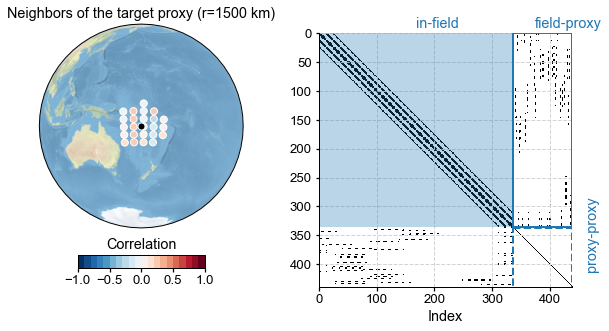

In [19]:
# an example of passing axes with map projections

# we need to first make a plot with map projections to get the specific projection,
# otherwise we have ot set it manually later
i = 20 # proxy index
fig_map, ax_map = g0.plot_neighbors(i)
cfr.closefig(fig_map)  # mute the figure

# now we make a new figure to include subplots generated by
# `plot_neighbors()` or `plot_neighbors_corr()` and `plot_adj()`
fig = plt.figure(figsize=[10, 5])
ax = {}
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.2, hspace=0.2)
# the 1st subplot will use the exact projection we had earlier
ax['map'] = fig.add_subplot(gs[0], projection=ax_map.projection)
ax['adj'] = fig.add_subplot(gs[1])
# we may call `plot_neighbors_corr()` since it has the same projection
ax['map'] = g0.plot_neighbors_corr(i, ax=ax['map'])
ax['adj'] = g0.plot_adj(ax=ax['adj'])

By construction, proxies are assumed conditionally independent of each other, so the proxy-proxy part of the adjacency matrix is diagonal. The climate-climate is block-diagonal, reflecting the fact that nearby indices tend to reflect nearby gridpoints, and nearby gridpoints generally have similar climates*.  There are discontinuities that happen when cycling through longitudes (0 --> 360 back to 0), which show up as abrupt breaks in the graph. The climate-proxy part is less regular, reflecting the fact that proxy locations are not uniformly spaced (unlike the grid points of the climate field). Notice how the overall matrix is very __sparse__: only a handful of of entries are non-zero (white is the main color on this plot). To be more precise, the `sparsity` property quantifies the fraction of non-zero entries:

In [20]:
g0.sparsity

[0.05653873489694385, 0.03345352564102564, 0.0]

We see that only a few % of the graph of the climate field and of the climate-proxy graph, have non-zero entries (the diagonal is excluded from this calculation, because a random variable is always conditionally dependent on itself; therefore, the proxy-proxy part of the graph has a sparsity of 0). This graph has achieved what we want: reducing the number of parameters to be estimated while computing the covariance matrix, which otherwise would be ill-conditioned. Will this suffice to yield a good estimate? Or have we thrown out the rubber duckies with the bath water and jettisoned too much information? The control knob here is the cutoff-radius. If it is too generous, the model is under-regularized; if it is too small, it could be over-regularized. What then is the optimal choice? Unfortunately, there is no theoretical criterion on how to choose an appropriate one. At a minimum, it should be larger than the largest spacing between nearby grid points (which tends to be largest at the equator). At most, it should be the circumference of the planet. That leaves quite some room in between. We will first carry out a preliminary reconstruction, before refining the choice of cutoff-radius via a process called [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

## Preliminary reconstruction

In [21]:
job.run_graphem?

Signature:
job.run_graphem(
    save_dirpath,
    load_precalculated=True,
    verbose=False,
    compress_params=None,
    recon_timescale=None,
    save_filename=None,
    **fit_kws,
)
Docstring:
Run the GraphEM solver, essentially the :py:meth: `GraphEM.solver.GraphEM.fit` method

Note that the arguments for :py:meth: `GraphEM.solver.GraphEM.fit` can be appended in the
argument list of this function directly. For instance, to pass a pre-calculated graph, use
`estimate_graph=False` and `graph=g.adj`, where `g` is the :py:`Graph` object.

Args:
    save_dirpath (str): the path to save the related results
    load_precalculated (bool, optional): load the precalculated `Graph` object. Defaults to False.
    verbose (bool, optional): print verbose information. Defaults to False.
    fit_kws (dict): the arguments for :py:meth: `GraphEM.solver.GraphEM.fit`

See also:
    cfr.graphem.solver.GraphEM.fit : fitting the GraphEM method
File:      ~/Github/cfr/cfr/reconjob.py
Type:      method


In [22]:
%%time
job.run_graphem(
    save_recon=True,
    save_dirpath='./results/graphem-ppe-pages2k',
    verbose=True,
    estimate_graph=False,
    graph=g0.adj,
)

>>> job.configs["save_dirpath"] = ./results/graphem-ppe-pages2k
>>> job.configs["compress_params"] = {'zlib': True, 'least_significant_digit': 1}
Using specified graph
Running GraphEM:

Iter     dXmis     rdXmis

001     0.0498     0.7232
002     0.1861     2.1704
003     0.0904     0.3866
004     0.0495     0.1568
005     0.0325     0.0928
006     0.0238     0.0639
007     0.0201     0.0516
008     0.0177     0.0439
009     0.0163     0.0393
010     0.0147     0.0346
011     0.0138     0.0319
012     0.0125     0.0284
013     0.0116     0.0259
014     0.0112     0.0248
015     0.0103     0.0225
016     0.0102     0.0221
017     0.0094     0.0201
018     0.0088     0.0188
019     0.0089     0.0190
020     0.0082     0.0173
021     0.0077     0.0161
022     0.0072     0.0152
023     0.0075     0.0157
024     0.0069     0.0143
025     0.0064     0.0133
026     0.0060     0.0124
027     0.0057     0.0117
028     0.0053     0.0110
029     0.0051     0.0104
030     0.0048     0.0099
031    

## Validation

In [24]:
res = cfr.ReconRes('./results/graphem-ppe-pages2k', verbose=True)

>>> res.paths:
['./results/graphem-ppe-pages2k/job_r01_recon.nc']


In [25]:
res.load(['nino3.4', 'tas'], verbose=True)

>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created
>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created


In [28]:
mask = (job.obs['tas'].time >= 1001) & (job.obs['tas'].time <= 2000)
target = job.obs['tas'].da.values[mask]
print(np.shape(target))

(1000, 12, 28)


### Mean Statistics

In [29]:
nt = np.size(res.recons['tas'].time)
field_r = job.graphem_solver.field_r
V = cfr.graphem.solver.verif_stats(
    field_r, target.reshape((nt, -1)),
    job.graphem_params['calib_idx'])
print(V)

Mean MSE = 0.1018, Mean RE = 0.5506, Mean CE = 0.4918, Mean R2 = 0.5691


In [36]:
print(np.shape(field_r))
print(np.shape(target))

(1000, 336)
(1000, 12, 28)


### Map of CE

In [30]:
ce = cfr.utils.coefficient_efficiency(target, res.recons['tas'].da.values)
print(np.shape(ce))

(12, 28)


/var/folders/4b/jg2fv7tn0g5gwzkq0s84c0ww0000gn/T/ipykernel_59519/2942537339.py:47: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(


Text(0.5, 1.0, 'CE')

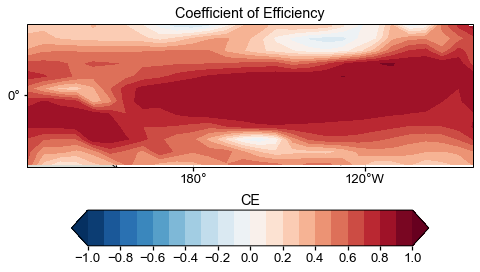

In [28]:
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

fig = plt.figure(figsize=[8, 8])
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title('Coefficient of Efficiency')
# latlon_range = [0, 360, -90, 90]
latlon_range = [122, 278, -25, 25]
transform=ccrs.PlateCarree()

ax.set_extent(latlon_range, crs=transform)
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

lon_ticks=[60, 120, 180, 240, 300]
lat_ticks=[-90, -45, 0, 45, 90]
lon_ticks = np.array(lon_ticks)
lat_ticks = np.array(lat_ticks)
lon_min, lon_max, lat_min, lat_max = latlon_range
mask_lon = (lon_ticks >= lon_min) & (lon_ticks <= lon_max)
mask_lat = (lat_ticks >= lat_min) & (lat_ticks <= lat_max)
ax.set_xticks(lon_ticks[mask_lon], crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks[mask_lat], crs=ccrs.PlateCarree())

levels = np.linspace(-1, 1, 21)
cbar_labels = np.linspace(-1, 1, 11)
cbar_title = 'CE'
extend = 'both'
cmap = 'RdBu_r'
cbar_pad=0.1
cbar_orientation='horizontal'
cbar_aspect=10
cbar_fraction=0.35
cbar_shrink=0.8
font_scale=1.5
land_color=sns.xkcd_rgb['light grey']
ocean_color=sns.xkcd_rgb['white']
        
ax.add_feature(cfeature.LAND, facecolor=land_color, edgecolor=land_color)
ax.add_feature(cfeature.OCEAN, facecolor=ocean_color, edgecolor=ocean_color)
ax.coastlines()
im = ax.contourf(job.obs['tas'].lon, job.obs['tas'].lat, ce, levels, transform=transform, cmap=cmap, extend=extend)
cbar = fig.colorbar(
    im, ax=ax, orientation=cbar_orientation, pad=cbar_pad, aspect=cbar_aspect,
    fraction=cbar_fraction, shrink=cbar_shrink)
cbar.set_ticks(cbar_labels)
cbar.ax.set_title(cbar_title)

### Timeseries comparison

In [29]:
job.obs['tas'].da

<xarray.DataArray 'tas' (year: 1156, lat: 12, lon: 28)>
array([[[-1.43779302, -1.16293697, -1.01732908, ...,  0.39457998,
          0.52082612,  0.59373487],
        [-0.44181921, -0.51548275,  0.244261  , ...,  0.74474864,
          0.77145844,  0.68355714],
        [ 0.35079578,  0.32100882,  0.55368277, ...,  0.88217642,
          0.68757142,  0.31475473],
        ...,
        [ 0.72816369,  0.71887253,  0.54529944, ...,  0.20676015,
          0.30845679,  0.2907033 ],
        [ 1.10758701,  0.98782858,  1.00810014, ...,  0.09055938,
          0.18384386,  0.24694595],
        [ 1.31631178,  1.20505177,  1.04198581, ...,  0.14300547,
          0.29674634,  0.27620213]],

       [[-0.70474708, -0.01598469,  0.13178037, ..., -0.16622394,
         -0.03184134, -0.0226782 ],
        [-0.47576783, -0.55773132, -0.46185074, ..., -0.03219556,
          0.01012642,  0.01045555],
        [ 0.10615215, -0.04668079, -0.21236786, ...,  0.06428793,
         -0.00198371, -0.03837104],
...
        [ 0.25181528,  0.44903654,  0.61978375, ...,  0.31308888,
          0.36723991,  0.52567691],
        [ 0.04978446,  0.04787485,  0.22568625, ...,  0.45198041,
          0.4664865 ,  0.49749394],
        [ 0.10458478, -0.10605026, -0.21279729, ...,  0.54345012,
          0.54446683,  0.52080011]],

       [[ 0.0498074 ,  0.27873075,  0.39957376, ..., -0.03960866,
         -0.05272122,  0.16753688],
        [-0.37810031,  0.30122609, -0.0628949 , ..., -0.11026585,
          0.06519481,  0.26313251],
        [ 0.08783609, -0.448483  , -0.12010821, ..., -0.0352111 ,
          0.10163381,  0.12676614],
        ...,
        [ 0.09630422,  0.35422082,  0.39387372, ...,  0.24968949,
          0.3645677 ,  0.26936438],
        [-0.06625534,  0.26004941,  0.47504105, ...,  0.32676493,
          0.46907017,  0.4533393 ],
        [-0.19586628,  0.12946299,  0.54914526, ...,  0.38060853,
          0.41296104,  0.51346773]]])
Coordinates:
  * year     (year) int64 850 851 852 853 854 855 ... 2001 2002 2003 2004 2005
  * lon      (lon) float64 121.9 127.7 133.5 139.4 ... 261.3 267.1 272.9 278.7
  * lat      (lat) float64 -24.15 -19.76 -15.37 -10.98 ... 15.37 19.76 24.15

In [31]:
da = cfr.utils.geo_mean(job.obs['tas'].da, lat_min=-5, lat_max=5, lon_min=np.mod(-170, 360), lon_max=np.mod(-120, 360))
da
ref_time = da.year.values
ref_value = da.values
ref_name = 'truth'

(1000.0, 2000.0)

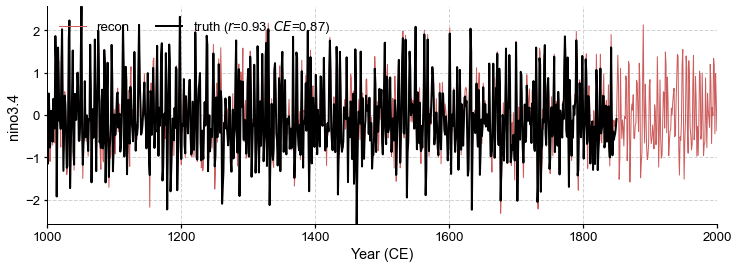

In [32]:
fig, ax = res.recons['nino3.4'].validate(
    ref_time, ref_value, ref_name, valid_period=[1001, 1850]).plot()
ax.set_xlim(1000, 2000)

In [33]:
lats, lons, colors, markers, markersizes = {}, {}, {}, {}, {}
for pobj in job.proxydb:
    pid = pobj.pid
    lats[pid] = pobj.lat
    lons[pid] = pobj.lon
    colors[pid] = cfr.visual.STYLE.colors_dict[pobj.ptype]
    markers[pid] = cfr.visual.STYLE.markers_dict[pobj.ptype]
    markersizes[pid] = 200

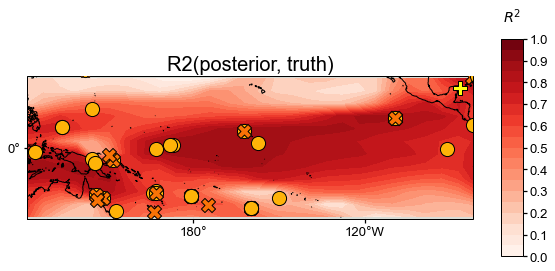

In [34]:
stat = 'R2'
valid_fd = res.recons['tas'].validate(
    job.obs['tas'], stat=stat,
    valid_period=(1750, 1850),
    interp_direction='from-ref',
)
fig, ax = valid_fd.plot(
    title=f'{stat}(posterior, truth)',
    projection='PlateCarree',
    latlon_range=(-25, 25, 122, 278),
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors,
    **valid_fd.plot_kwargs)